Q-Algo Overview: 
Transform a slowly converging sequence into a new sequence that converges faster to the same limit. Interative numerical methods - helps with computational performance. 

Uses recursive formulas to generate a sequence of approxmiations that converge more rapidly. Applies specific transformations to the elements of the original equence. Satisfies the Bellman Optimality Equation, which connects the exploration and exploitation strategy with the actual learning progress. The Bellman Optmality Equation for Q-Values is given by 

$ Q(s,a) = r + \gamma maxQ(s^{'}, a^{'}) $

Where current state (s) and current actiaon taken (a) is the sum of the immediate reward after taking action a in state s (r) ply discount factor (gamma) times the max of the next q-value from taking action a in state s. 
Q-Learning with FrozenLake Environment. 

Exploration vs Exploitation in Q-Learning. 

Exploitation means the agent selects the action that currently has the highest Q-value based on its learned experiences so far. It directly applies the Bellman Optimality Equation to update the Q-values because it uses the highest expected future reward from the chosen action to adjust its current Q-value. 

Exploration means the agent triends a random action, regardless of its current Q-values. This randomness allows the agent to gather new information about the environment. Agent might unexpectedly discover high rewards and the newly observed rewards are used to update the Q-values using Bellman Equation. 

With each exploration, there is an exponential decay formula which controls the speed at which the exploration probabilty decreases, meaning faster decay = agent exploit its knowledge sooner. 


Building the following trading simulation.

You can trade three stocks: Apple, Coca-Cola, and IBM.

Your portfolio is rebalanced every week and held for a week.

At the beginning of each week, you make a decision to adjust your portfolio holding based on the following state variables: last week's return on these 3 stocks and your current holding on these three stocks.

Your simulation (episode) starts in the beginning of 2010 with an initial cash holding of 100

Your simulation (episode) terminates if the following conditions are met: your current cash holding + your current portfolio value <= 0 dollar. OR you have reached the end of the year 2017.

Your actions are to long 1 share, short 1 share, stay neutral for each stock -- your actions are three dimensional vectors.

At the end of each period, determine whether your simulation has ended by checking the date and the sum of your cash holding and portfolio value. The portofolio value is the sum of the value of the three stocks in your portfolio based on how many shares you hold.

When you commit an action, the immediate reward is the gain of the shares sold (shorted) minus the cost of the number of shares bought. We ignore the transaction cost here. When you reach the end, you receive an additional reward that is equal to the value of your portfolio at the end.

First build this experiment, and then plot the trajectory of your networth: cash+portfolio value over time under a random policy (randomly choosing actions at each state). Use a random state of 123. Assume no discounting. Use the data from Yahoo Finance.

In [66]:
!pip install yfinance

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 8.0 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 12.0 MB/s eta 0:00:00a 0:00:01
  Created wheel for frozendict: filename=frozendict-2.4.4-cp38-cp38-macosx_10_9_x86_64.whl size=37809 sha256=9dc20a7e89e7bce1d4006635c01f1c6581dcebe3d4048901628a3b31890da07b
  Stored in directory: /Users/ziyuechen/Library/Caches/pip/wheels/7d/65/20/a8f7d1a2a99c9db2dfb0f83dddac9e847b02f45040768bf264
  Created wheel for peewee: filename=peewee-3.17.6-cp38-cp38-macosx_10_9_x86_64.whl size=267562 sha256=1c26d3bf64884345d40d099ca70d0d00e531a0a0406364e804550aacfba9ac18
  Stored in directory: /Users/ziyuechen/Library/Caches/pip/wheels/3a/cd/3a/abf2568bf80fd9

In [77]:
import numpy as np # to access and update the Q-table
import gym # to use FrozenLake Evironment

# Imports
from strategy.actions import random_action
from data.fetch_data import fetch_data
from data.process_data import calculate_returns
from visualizations.plot_results import plot_net_worth, plot_cash, plot_portfolio_value, plot_rewards
from simulations.run_simulation import run_simulation
from collections import defaultdict

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [68]:
# Download historical data for Apple, Coca-Cola, and IBM from 2010 to 2017
tickers = ['AAPL', 'KO', 'IBM']
start_date = "2010-01-01"
end_date = "2017-12-31"

data = fetch_data(tickers, start_date, end_date)
rets = calculate_returns(data)
data

[*********************100%***********************]  3 of 3 completed


Ticker,AAPL,IBM,KO
Date,,,
2010-01-01 00:00:00+00:00,6.351057,73.703911,17.938576
2010-01-08 00:00:00+00:00,6.316373,75.274170,18.238659
2010-01-15 00:00:00+00:00,6.275357,73.390991,17.357538
2010-01-22 00:00:00+00:00,6.010553,70.404182,17.296885
2010-01-29 00:00:00+00:00,5.792196,69.977470,17.057453
...,...,...,...
2017-12-01 00:00:00+00:00,39.876526,107.056374,37.264786
2017-12-08 00:00:00+00:00,40.559505,107.356155,37.468285
2017-12-15 00:00:00+00:00,41.216579,105.613365,37.118263


In [79]:
np.random.seed(123)

# Initial settings
initial_cash = 100
portfolio = {'AAPL': 0, 'KO': 0, 'IBM': 0}
cash = initial_cash
net_worth_history = []

In [80]:
# Step 2: Helper Functions

def calculate_portfolio_value(holdings, prices):
    """
    Calculate the total value of the portfolio based on current holdings and prices.
    """
    value = sum(holdings[ticker] * prices[ticker] for ticker in tickers)
    return value

def get_state(returns, holdings):
    """
    Get the current state representation by combining last week's returns and current holdings.
    """
    ret_state = tuple(np.digitize(returns, bins=[-0.02, 0, 0.02]) + 1)  # Discretize returns into 3 states: Down, Neutral, Up
    hold_state = tuple(holdings.values())  # Holding states: -1 (short), 0 (neutral), 1 (long)
    return ret_state + hold_state

def update_holdings(holdings, action):
    """
    Update holdings based on the selected action: long, short, or neutral.
    """
    new_holdings = holdings.copy()
    for i, ticker in enumerate(tickers):
        if action[i] == 1:  # Long one share
            new_holdings[ticker] += 1
        elif action[i] == -1:  # Short one share
            new_holdings[ticker] -= 1
    return new_holdings

def calculate_reward(holdings, prices, action):
    """
    Calculate the immediate reward based on the action taken.
    """
    reward = sum(action[i] * prices[ticker] for i, ticker in enumerate(tickers))  # Gain from shorting, cost from buying
    return reward

def evaluate_continuation(cash, holdings, prices):
    """
    Check if the simulation should continue based on current net worth.
    """
    portfolio_value = calculate_portfolio_value(holdings, prices)
    net_worth = cash + portfolio_value
    return net_worth > 0


In [81]:
# Step 3: Q-Learning Parameters and Initialization
n_episodes = 1000
alpha = 0.1  # Learning rate
gamma = 1.0  # No discounting
epsilon = 0.1  # Exploration rate

In [82]:
# Initialize Q-table using a defaultdict of float
Q_table = defaultdict(float)

# Track net worth over time for each episode
net_worth_history = []

# Step 4: Run the Q-Learning Simulation
for episode in range(n_episodes):
    # Initialize cash and holdings
    cash = 100
    holdings = {'AAPL': 0, 'KO': 0, 'IBM': 0}
    
    # Iterate over each week
    episode_net_worth = []
    for t in range(1, len(data) - 1):
        last_returns = data.pct_change().iloc[t - 1]  # Last week's returns
        current_prices = data.iloc[t]  # Current prices
        
        # Get the current state
        state = get_state(last_returns, holdings)
        
        # Choose action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = np.random.choice([-1, 0, 1], size=3)  # Random action: short, neutral, or long
        else:
            # Exploit: Choose action with highest Q-value
            action_values = {(-1, 0, 1) : Q_table[(state, (-1, 0, 1))], 
                              (0, 0, 0) : Q_table[(state, (0, 0, 0))],
                              (1, 0, -1): Q_table[(state, (1, 0, -1))]}  # Modify according to possible actions
            action = max(action_values, key=action_values.get)
        
        # Calculate immediate reward and update holdings
        reward = calculate_reward(holdings, current_prices, action)
        cash += reward
        holdings = update_holdings(holdings, action)
        
        # Calculate the next state
        next_returns = data.pct_change().iloc[t]
        next_state = get_state(next_returns, holdings)
        
        # Update Q-table using the Q-learning update rule
        Q_table[(state, action)] += alpha * (reward + gamma * max(Q_table[(next_state, a)] for a in action_values.keys()) - Q_table[(state, action)])
        
        # Track net worth and check continuation
        portfolio_value = calculate_portfolio_value(holdings, current_prices)
        net_worth = cash + portfolio_value
        episode_net_worth.append(net_worth)
        
        if not evaluate_continuation(cash, holdings, current_prices):
            break  # Stop the episode if net worth is zero or negative
    
    # Store the net worth trajectory of the episode
    net_worth_history.append(episode_net_worth)


TypeError: unhashable type: 'numpy.ndarray'

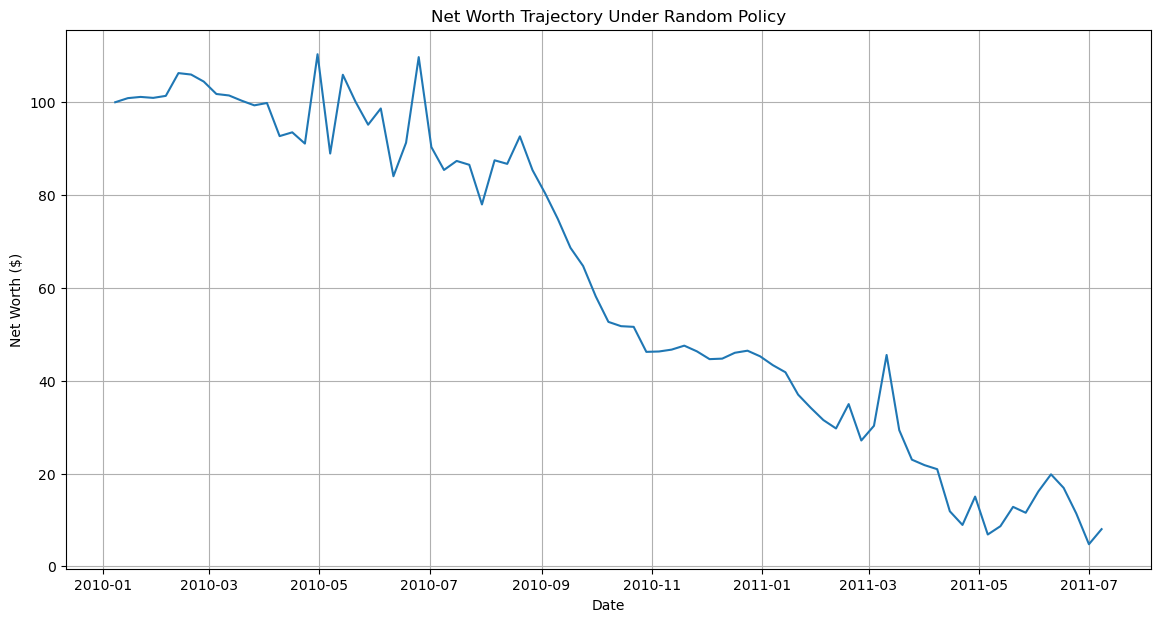

In [72]:
# Step 5: Plot Net Worth Trajectory
plt.figure(figsize=(12, 6))
for i, net_worth in enumerate(net_worth_history[:10]):  # Plot the first 10 episodes
    plt.plot(net_worth, label=f'Episode {i+1}')
plt.xlabel('Weeks')
plt.ylabel('Net Worth ($)')
plt.title('Net Worth Trajectory Over Time')
plt.legend()
plt.grid(True)
plt.show()